In [1]:
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img, img_to_array

from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Reshape, Conv2DTranspose, BatchNormalization, LeakyReLU
from keras.layers import Activation, Conv2D, Lambda, Concatenate, Flatten, Dense, UpSampling2D

from keras.utils import np_utils
import keras
import colorsys
import keras.backend as K
import glob
import json
from sklearn.model_selection import train_test_split
from io import BytesIO
import PIL
from IPython.display import clear_output, Image, display, HTML

import math
import random

import numpy as np
import matplotlib.pyplot as plt

import cv2

Using TensorFlow backend.


In [2]:
BATCH_SIZE = 32
LATENT_SIZE = 128

In [3]:
def augment(icons):
    aug_icons = []
    for icon in icons:
        for flip in range(4):
            for rotation in range(4):
                aug_icons.append(icon)
                icon = np.rot90(icon)
            icon = np.fliplr(icon)
    return np.asarray(aug_icons)
        

def load_icons(train_size=0.85):
    icon_index = json.load(open('icons/index.json'))
    x = []
    img_rows, img_cols = 32, 32
    for icon in icon_index:
        if icon['name'].endswith('_filled'):
            continue
        img_path = 'icons/png32/%s.png' % icon['name']
        img = load_img(img_path, grayscale=True, target_size=(img_rows, img_cols))
        img = img_to_array(img)
        x.append(img)
    x = np.asarray(x) / 255
    x_train, x_val = train_test_split(x, train_size=train_size)
    return augment(x_train), augment(x_val)

x_train, x_test = load_icons()
x_train.shape, x_test.shape

((62992, 32, 32, 1), (11120, 32, 32, 1))

In [4]:
def create_generative_network(latent_size):
    inp = Input(shape=(latent_size,))
    x = Reshape((1, 1, latent_size))(inp)

    channels = latent_size
    padding = 'valid'
    strides = 1
    for i in range(4):
        x = Conv2DTranspose(channels, kernel_size=4,
                            strides=strides, padding=padding)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(.2)(x)
        
        channels //= 2
        padding = 'same'
        strides = 2

    x = Conv2DTranspose(1, kernel_size=4, strides=1, padding='same')(x)
    image_out = Activation('tanh')(x)

    model = Model(inputs=inp, outputs=image_out)
    return model

generator = create_generative_network(LATENT_SIZE)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128)               0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 1, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 4, 4, 128)         262272    
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 8, 8, 64)          131136    
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 64)          256       
__________

In [5]:
def create_discriminative_network():
    inp = Input(shape=(32, 32, 1))
    x = inp

    channels = 16

    for i in range(4):
        layers = []
        conv = Conv2D(channels, 3, strides=2, padding='same')(x)
        if i:
            conv = BatchNormalization()(conv)
        conv = LeakyReLU(.2)(conv)
        layers.append(conv)
        bv = Lambda(lambda x: K.mean(K.abs(x[:] - K.mean(x, axis=0)), 
                                     axis=-1, 
                                     keepdims=True))(conv)
        layers.append(bv)
        channels *= 2
        x = Concatenate()(layers)

    x = Conv2D(128, 2, padding='valid')(x)
    x = Flatten(name='flatten')(x)
    
    fake = Dense(1, activation='sigmoid', name='generation')(x)

    m = Model(inputs=inp, outputs=fake)
    return m

discriminator = create_discriminative_network()
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 16)        160       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 16)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 16, 16, 1)         0         
_________________________________________________________________
concatenate_1 (Concatenate)  (None, 16, 16, 17)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          4928      
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 32)          128       
__________

In [6]:
def gan(g, d):
    # initialize a GAN trainer

    # this is the fastest way to train a GAN in Keras
    # two models are updated simutaneously in one pass

    noise = Input(shape=g.input_shape[1:])
    real_data = Input(shape=d.input_shape[1:])

    generated = g(noise)
    gscore = d(generated)
    rscore = d(real_data)

    def log_eps(i):
        return K.log(i+1e-11)

    # single side label smoothing: replace 1.0 with 0.9
    dloss = - K.mean(log_eps(1-gscore) + .1 * log_eps(1-rscore) + .9 * log_eps(rscore))
    gloss = - K.mean(log_eps(gscore))

    Adam = tf.train.AdamOptimizer

    lr, b1 = 1e-4, .2 # otherwise won't converge.
    optimizer = Adam(lr,beta1=b1)

    grad_loss_wd = optimizer.compute_gradients(dloss, d.trainable_weights)
    update_wd = optimizer.apply_gradients(grad_loss_wd)

    grad_loss_wg = optimizer.compute_gradients(gloss, g.trainable_weights)
    update_wg = optimizer.apply_gradients(grad_loss_wg)

    def get_internal_updates(model):
        # get all internal update ops (like moving averages) of a model
        inbound_nodes = model.inbound_nodes
        input_tensors = []
        for ibn in inbound_nodes:
            input_tensors+= ibn.input_tensors
        updates = [model.get_updates_for(i) for i in input_tensors]
        return updates

    other_parameter_updates = [get_internal_updates(m) for m in [d,g]]
    # those updates includes batch norm.

    train_step = [update_wd, update_wg, other_parameter_updates]
    losses = [dloss, gloss]

    learning_phase = K.learning_phase()

    def gan_feed(sess,batch_image,z_input):
        # actual GAN trainer
        nonlocal train_step,losses,noise,real_data,learning_phase

        res = sess.run([train_step,losses],feed_dict={
        noise:z_input,
        real_data:batch_image,
        learning_phase:True,
        # Keras layers needs to know whether
        # this run is training or testring (you know, batch norm and dropout)
        })

        loss_values = res[1]
        return loss_values #[dloss,gloss]

    return gan_feed

print('generating GAN...')
gan_feed = gan(generator, discriminator)

generating GAN...


In [7]:
def generate_images(generator, count):
    noise = np.random.normal(loc=0., 
                             scale=1., 
                             size=(count, LATENT_SIZE))
    for tile in generator.predict([noise]).reshape((count, 32, 32)):
        tile = (tile * 300).clip(0, 255).astype('uint8')
        yield PIL.Image.fromarray(tile)

def poster(generator, w_count, h_count):
    overview = PIL.Image.new('RGB', (w_count * 34 + 2, h_count * 34 + 2), (128, 128, 128))
    for idx, img in enumerate(generate_images(generator, w_count * h_count)):
        x = idx % w_count
        y = idx // w_count
        overview.paste(img, (x * 34 + 2, y * 34 + 2))
    return overview


0 dloss: 0.54 gloss: 2.25


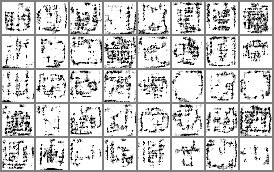

In [8]:
def run(epochs=100):
    sess = K.get_session()
    l = x_train.shape[0]
    l -= l % BATCH_SIZE
    for epoch in range(epochs):
        np.random.shuffle(x_train)
        for batch_start in range(0, l, BATCH_SIZE):
            batch = x_train[batch_start: batch_start + BATCH_SIZE]
            z_input = np.random.normal(loc=0., 
                                       scale=1., 
                                       size=(BATCH_SIZE, LATENT_SIZE))
            dloss, gloss = gan_feed(sess, batch, z_input)
        clear_output(wait=True)
        print('%d dloss: %2.2f gloss: %2.2f' % (epoch, dloss, gloss))
        f = BytesIO()
        poster(generator, 8, 5).save(f, 'png')
        display(Image(data=f.getvalue()))
run(1)

9 dloss: 0.34 gloss: 5.49


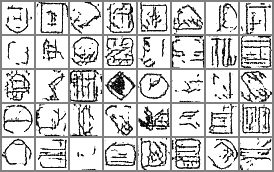

In [12]:
run(30)

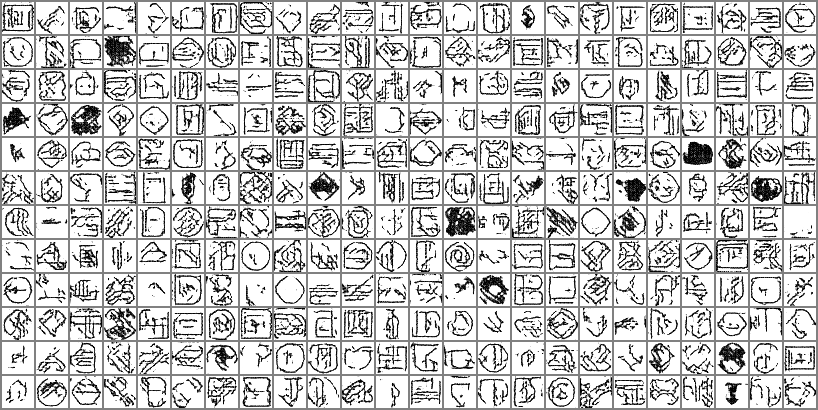

In [13]:
f = BytesIO()
poster(generator, 24, 12).save(f, 'png')
display(Image(data=f.getvalue()))